# Bank marketing campaign analysis

**About dataset**

This is dataset that describe Portugal bank marketing campaigns results. Conducted campaigns were based mostly on direct phone calls, offering bank's clients to place a term deposit. If after all marking afforts client had agreed to place deposit - target variable marked 'yes', otherwise 'no'.

Data's Sources: https://www.kaggle.com/datasets/volodymyrgavrysh/bank-marketing-campaigns-dataset/data

**Objectives**

- Predicting the future results of marketing campaigns based on available statistics and, accordingly, formulating recommendations for such campaigns in the future.
- Building a profile of a consumer of banking services.

**Approach**

There are 5 steps to acquire these objects:

    1. Load and explore data

    2. Exploratory data analysis

    3. Data cleaning and data preparation for modeling

    4. Building models
    
    5. Conclusions and recommendations

In [30]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import sklearn
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
warnings.filterwarnings('ignore')

## 1. Load and explore data

In [31]:
# read data
df = pd.read_csv(r'C:\Users\TGDD\OneDrive - National Economics University\Desktop\Bank marketing\bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [33]:
# Check the information
print(f'There are {df.shape[0]} observations and {df.shape[1]} features')
df.info()

There are 41188 observations and 21 features
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null 

## 2. Exploratory data analysis 

In [91]:
# build a function to show features's distribution
def show_distribution(column):
    df_bar = df.groupby([column, 'y']).count()
    df_bar = df_bar.reset_index()
    df_bar = df_bar.rename(columns={'y': 'term_deposit'})
    
    plt.figure(figsize=(4,3))
    sns.barplot(
        data = df_bar,
        x = df_bar[column],
        y = df_bar['emp.var.rate'],
        hue= df_bar['term_deposit']
    )
    plt.ylabel('number of client')
    plt.xticks(rotation = 80)
    plt.show()

**Features of client's data**

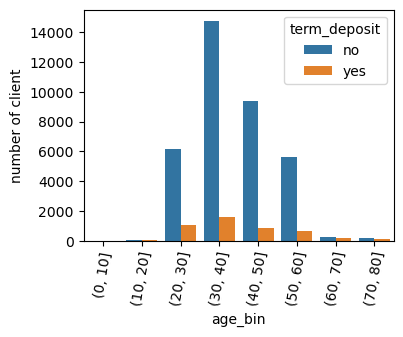

In [89]:
df2 = df
bins = [0,10,20,30,40,50,60,70,80]
df2['age_bin'] = pd.cut(df['age'], bins)
show_distribution('age_bin')

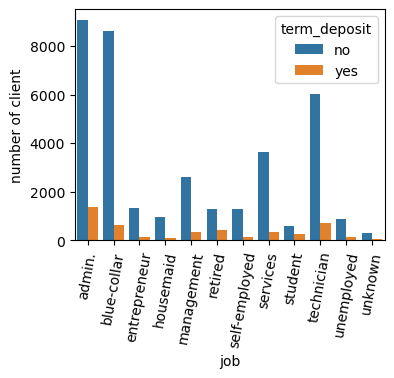

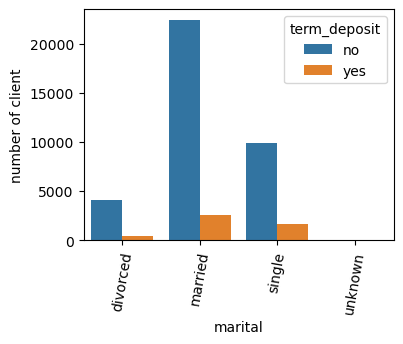

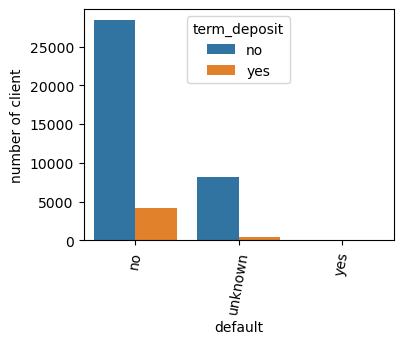

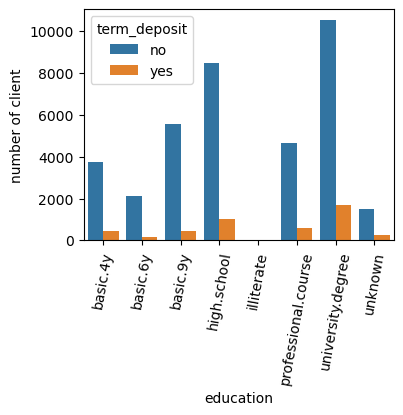

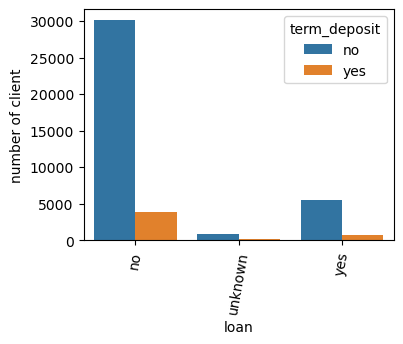

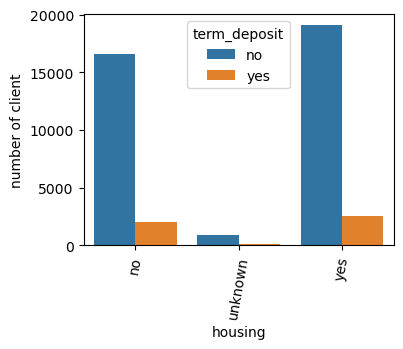

(None, None)

In [84]:
show_distribution('job'), show_distribution('marital'), show_distribution('default'), show_distribution('education'), 
show_distribution('loan'), show_distribution('housing')

**Features related with the last contact of the current campaign**

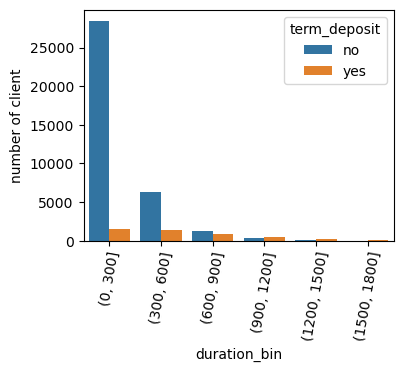

In [100]:
bin2 = [0,300,600,900,1200,1500,1800]
df2['duration_bin'] = pd.cut(df2['duration'], bin2)
show_distribution('duration_bin')


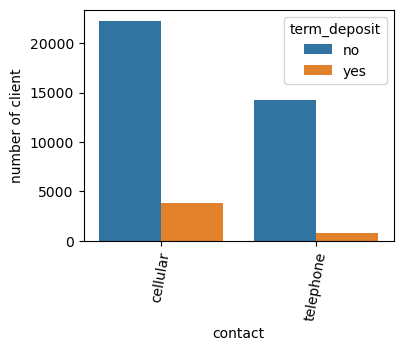

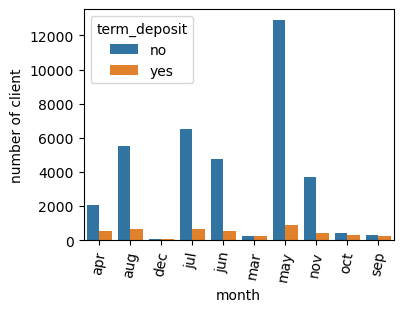

(None, None)

In [101]:
show_distribution('contact'), show_distribution('month')

**Quick insight:**

- The group aged 30-40 had the highest number of agreements, but the group 20-30 had the highest agreement rate.

- The groups that graduated from high school and university were approached the most frequently and had the highest number of people agreeing.

- Contact time with customers was usually less than 5 minutes. However, the longer the contact, the higher the likelihood of the customer agreeing.

- The largest number of customers were approached and agreed to open accounts in May.

- Most customers had not had a term deposit account yet.

## 3. Data cleaning and data preparation for modeling

In [38]:
# Prepare dataframe with discrete variables
df_discrete = df[['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 
                  'month', 'day_of_week', 'poutcome', 'y']]

In [39]:
# Encode the dataframe with discrete variables
from sklearn.preprocessing import LabelEncoder
df_discrete = df_discrete.apply(LabelEncoder().fit_transform)

In [40]:
# Prepare dataframe with continuous variables
df_con = df[['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
              'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']]

In [41]:
# Normalize the continuous variables
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df_con)
df_con = pd.DataFrame(scaler.transform(df_con), columns= df_con.columns)

In [42]:
# Concat the two dataframes into a single dataframe
df_prepared = pd.concat((df_discrete, df_con), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [43]:
# find duplicates:
print(f'the number of duplicated data is: {df_prepared.duplicated().sum()}')

the number of duplicated data is: 12


In [44]:
# drop duplicates:
df_prepared = df_prepared.drop_duplicates(keep= 'first')
print(f'After removing duplicates, there are {df_prepared.shape[0]} observations and {df_prepared.shape[1]} features')

After removing duplicates, there are 41176 observations and 21 features


In [45]:
df_prepared.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,...,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,3,1,0,0,0,0,1,6,1,1,...,0.481481,0.053070,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735
1,7,1,3,1,0,0,1,6,1,1,...,0.493827,0.030297,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735
2,7,1,3,0,2,0,1,6,1,1,...,0.246914,0.045954,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735
3,0,1,1,0,0,0,1,6,1,1,...,0.283951,0.030704,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735
4,7,1,3,0,0,2,1,6,1,1,...,0.481481,0.062424,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735


In [46]:
df_prepared.corr().style.background_gradient()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
job,1.000000,0.027829,0.134159,-0.028282,0.006873,-0.010161,-0.025054,-0.033007,-0.000868,0.011485,0.025248,0.001270,-0.006408,-0.006865,-0.028494,0.021007,-0.008443,-0.016122,0.052802,-0.008024,-0.019728
marital,0.027829,1.000000,0.109195,-0.079432,0.010499,0.005806,-0.054527,-0.007622,0.002174,0.001905,0.046249,-0.389829,0.010278,-0.007189,-0.037955,0.038708,-0.084142,-0.057431,-0.033821,-0.091881,-0.086134
education,0.134159,0.109195,1.000000,-0.186811,0.016891,0.006441,-0.105722,-0.082739,-0.017989,0.016987,0.057776,-0.117960,-0.015086,0.000406,-0.046656,0.038880,-0.043695,-0.081499,0.078789,-0.036321,-0.041455
default,-0.028282,-0.079432,-0.186811,1.000000,-0.015790,-0.003823,0.135275,-0.015787,-0.008660,0.023437,-0.099364,0.164939,-0.011805,0.032809,0.080086,-0.102458,0.203257,0.168076,0.026502,0.195335,0.189846
housing,0.006873,0.010499,0.016891,-0.015790,1.000000,0.044272,-0.082098,-0.018050,0.003339,-0.011771,0.011613,-0.001477,-0.007688,-0.011074,-0.010539,0.021293,-0.060248,-0.080579,-0.033665,-0.059283,-0.045892
loan,-0.010161,0.005806,0.006441,-0.003823,0.044272,1.000000,-0.008589,-0.005738,-0.009345,-0.001486,-0.004922,-0.007359,-0.000970,0.005119,0.000371,-0.001374,0.001840,-0.002474,-0.012002,0.000125,0.003910
contact,-0.025054,-0.054527,-0.105722,0.135275,-0.082098,-0.008589,1.000000,0.276499,-0.009614,0.118773,-0.144774,0.006917,-0.026665,0.077387,0.117999,-0.212903,0.393730,0.591596,0.251575,0.399892,0.269285
month,-0.033007,-0.007622,-0.082739,-0.015787,-0.018050,-0.005738,0.276499,1.000000,0.027683,-0.065010,-0.006051,-0.025023,0.003637,-0.062128,-0.047885,0.103151,-0.178724,-0.004183,0.009551,-0.117216,-0.221370
day_of_week,-0.000868,0.002174,-0.017989,-0.008660,0.003339,-0.009345,-0.009614,0.027683,1.000000,0.018733,0.015970,-0.017614,0.021990,-0.038254,-0.009531,-0.004103,0.033288,0.005674,0.041405,0.039064,0.028414
poutcome,0.011485,0.001905,0.016987,0.023437,-0.011771,-0.001486,0.118773,-0.065010,0.018733,1.000000,0.129810,0.019750,0.033385,0.032607,-0.475635,-0.313098,0.193015,0.211381,0.178318,0.184173,0.119705


## 4. Building models

In [47]:
# Split data into train and test set:
from sklearn.model_selection import train_test_split
X = df_prepared.drop(columns = 'y')
y = df_prepared['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [48]:
print('The shape of train set and test set: ', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

The shape of train set and test set:  (32940, 20) (8236, 20) (32940,) (8236,)


### 4.1. Logistic regression

In [49]:
# fit model:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [50]:
# predict train set:
y_pred_lr = lr.predict(X_test)

<Figure size 400x400 with 0 Axes>

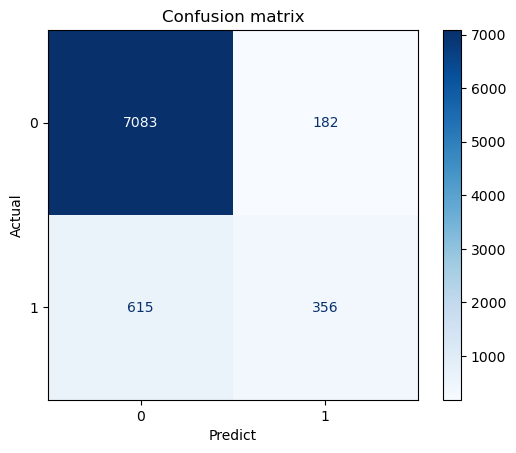

In [51]:
# confusion matrix:
plt.figure(figsize = (4,4))
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_lr)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot(cmap= 'Blues')
plt.title('Confusion matrix')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [52]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7265
           1       0.66      0.37      0.47       971

    accuracy                           0.90      8236
   macro avg       0.79      0.67      0.71      8236
weighted avg       0.89      0.90      0.89      8236



### 4.2. Gaussian Naive Bayes classifier

In [53]:
# fit model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [54]:
# predict test set:
y_pred_gnb = gnb.predict(X_test)

<Figure size 400x400 with 0 Axes>

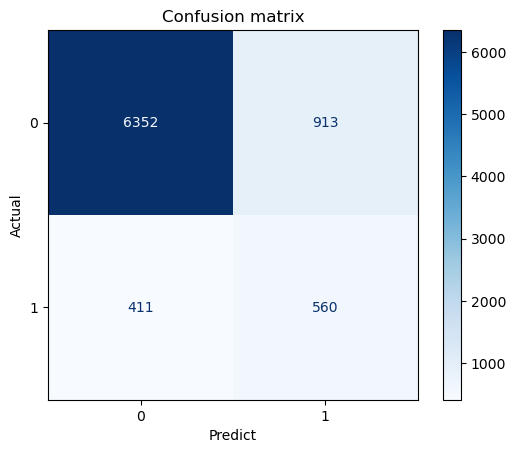

In [55]:
# confusion matrix:
plt.figure(figsize = (4,4))
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_gnb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot(cmap= 'Blues')
plt.title('Confusion matrix')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [56]:
print(classification_report(y_test, y_pred_gnb))

              precision    recall  f1-score   support

           0       0.94      0.87      0.91      7265
           1       0.38      0.58      0.46       971

    accuracy                           0.84      8236
   macro avg       0.66      0.73      0.68      8236
weighted avg       0.87      0.84      0.85      8236



### 4.3. Decision tree classifier

In [57]:
# fit model:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [58]:
# predict test set:
y_pred_dt = dt.predict(X_test)

<Figure size 400x400 with 0 Axes>

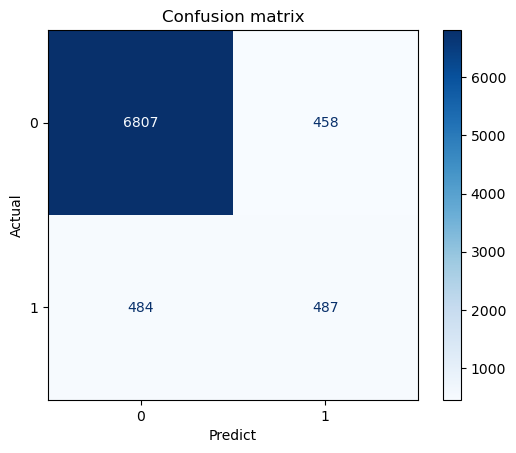

In [59]:
# confusion matrix:
plt.figure(figsize = (4,4))
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_dt)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot(cmap= 'Blues')
plt.title('Confusion matrix')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [60]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      7265
           1       0.52      0.50      0.51       971

    accuracy                           0.89      8236
   macro avg       0.72      0.72      0.72      8236
weighted avg       0.88      0.89      0.88      8236



### 4.4. Random forest classifier

In [61]:
accuracy_score_lst = []
for i in range(1,100,1):
    rf = RandomForestClassifier(n_estimators= 50, random_state= i)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    accuracy_score_lst.append(accuracy_score(y_test, y_pred_rf))
    
max_score = 0
n_max_score = 0
n = 0
while n < len(accuracy_score_lst):
    if accuracy_score_lst[n] >= max_score:
        max_score = accuracy_score_lst[n]
        n_max_score = n
    n+=1
print(f'with random state is: {n_max_score + 1}, the accuracy score is maximum at: {max_score*100:,.2f}%')

with random state is: 18, the accuracy score is maximum at: 91.34%


In [62]:
# fit model and predict test set:
rf_max = RandomForestClassifier(n_estimators= 50, random_state=18)
rf_max.fit(X_train, y_train)
y_pred_rf2 = rf.predict(X_test)

<Figure size 400x400 with 0 Axes>

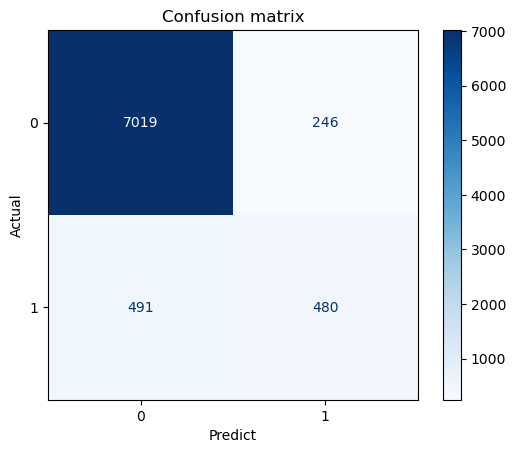

In [63]:
# confusion matrix:
plt.figure(figsize = (4,4))
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot(cmap= 'Blues')
plt.title('Confusion matrix')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [64]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7265
           1       0.66      0.49      0.57       971

    accuracy                           0.91      8236
   macro avg       0.80      0.73      0.76      8236
weighted avg       0.90      0.91      0.90      8236



### 4.5. KNeighbors Classifier

In [65]:
# fit model
kn = KNeighborsClassifier(n_neighbors= 10)
kn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [66]:
# predict test set:
y_pred_kn = dt.predict(X_test)

<Figure size 400x400 with 0 Axes>

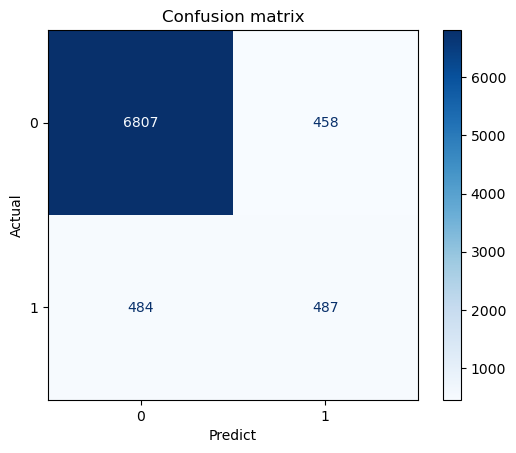

In [67]:
# confusion matrix:
plt.figure(figsize = (4,4))
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_kn)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot(cmap= 'Blues')
plt.title('Confusion matrix')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [68]:
print(classification_report(y_test, y_pred_kn))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      7265
           1       0.52      0.50      0.51       971

    accuracy                           0.89      8236
   macro avg       0.72      0.72      0.72      8236
weighted avg       0.88      0.89      0.88      8236



### 4.6. Compare models

In [69]:
# calculate the accuracy scores and the ROC_AUC scores of models:
y_pred_lr_prob = lr.predict_proba(X_test)[:,1]
y_pred_kn_prob = kn.predict_proba(X_test)[:,1]
y_pred_gnb_prob = gnb.predict_proba(X_test)[:,1]
y_pred_dt_prob = dt.predict_proba(X_test)[:,1]
y_pred_rf_prob = rf.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test, y_pred_lr_prob)
fpr_kn, tpr_kn, threshold_kn = roc_curve(y_test, y_pred_kn_prob)
fpr_gnb, tpr_gnb, threshold_gnb = roc_curve(y_test, y_pred_gnb_prob)
fpr_dt, tpr_dt, threshold_dt = roc_curve(y_test, y_pred_dt_prob)
fpr_rf, tpr_rf, threshold_rf = roc_curve(y_test, y_pred_rf_prob)
AUC_lr = auc(fpr_lr, tpr_lr)
AUC_kn = auc(fpr_kn, tpr_kn)
AUC_gnb = auc(fpr_gnb, tpr_gnb)
AUC_dt = auc(fpr_dt, tpr_dt)
AUC_rf = auc(fpr_rf, tpr_rf)
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_kn = accuracy_score(y_test, y_pred_kn)
acc_gnb = accuracy_score(y_test, y_pred_gnb)
acc_dt = accuracy_score(y_test, y_pred_dt)
acc_rf = accuracy_score(y_test, y_pred_rf)

In [71]:
# create dataframe
compare_df = pd.DataFrame()
compare_df['models'] = ['logistic regression', 'kneighbors', 'gaussian naive bayes', 'decision tree', 'random forest']
compare_df['ROC_AUC'] = [AUC_lr, AUC_kn, AUC_gnb, AUC_dt, AUC_rf]
compare_df['accuracy'] = [acc_lr, acc_kn, acc_gnb, acc_dt, acc_rf]

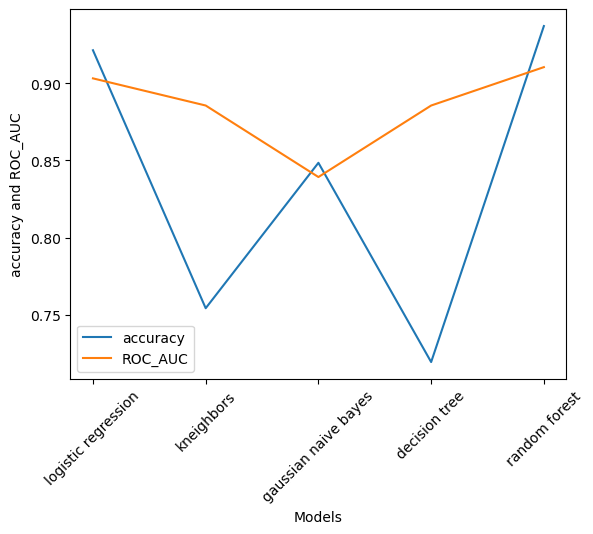

In [72]:
# draw a plot
plt.figure()
plt.plot(compare_df['models'], compare_df['ROC_AUC'])
plt.plot(compare_df['models'], compare_df['accuracy'])
plt.xlabel('Models')
plt.xticks(rotation = 45)
plt.ylabel('accuracy and ROC_AUC')
plt.legend(['accuracy', 'ROC_AUC'])
plt.show()

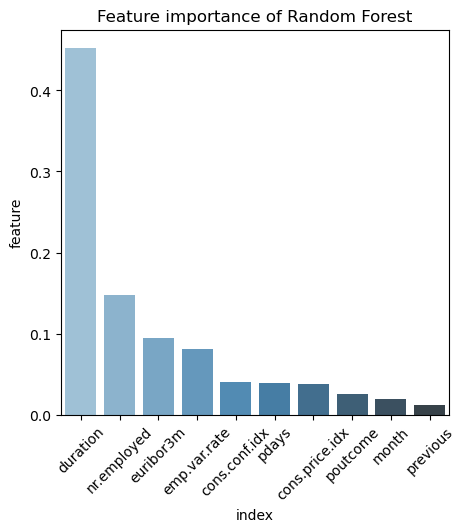

In [102]:
# feature importance
def build_feature_importance(model, X_train, y_train):
    
    models = RandomForestClassifier(criterion='entropy', random_state=18, oob_score=True, n_jobs=-1, \
                           max_depth=25, min_samples_leaf=80, min_samples_split=3, n_estimators=70)
    models.fit(X_train, y_train)
    data = pd.DataFrame(models.feature_importances_, X_train.columns, columns=["feature"])
    data = data.sort_values(by='feature', ascending=False).reset_index()
    plt.figure(figsize=[5,5])
    sns.barplot(x='index', y='feature', data=data[:10], palette="Blues_d")
    plt.title('Feature importance of Random Forest')
    plt.xticks(rotation=45)
    plt.show();
    
build_feature_importance(RandomForestClassifier, X_train, y_train)

## 5. Conclusions and recommendations 

**Conclusions:**

- By analyse models, the variable with the highest influence on customer agreements is contact duration (duration), followed by contextual variables such as number of employees, interest rate, credit ratio. employment, consumer confidence, consumer price index.

- The influence of the last contacts such as the number of days since the last contact, the results of the previous campaign, the last month of contact, and the number of contacts before the campaign also have a certain impact on customer decisions.

**Recommendations:**

- Increasing customer communication and consulting time will increase the likelihood of customer agreements.

- May is the peak month with a large number of customers.

- Be aware of the influence of macroeconomic factors every time startong a new campaign.

- Enhance the quality of consulting and customer care through campaigns to have better results for that future campaigns